Case: Two-Product Production Mix with Shared Capacity

A manufacturer is introducing two new products:

Product D (a premium glass door with an aluminum frame)

Product W (a wood-framed window)

Production uses three plants:

Plant 1: aluminum components

Plant 2: wood components

Plant 3: glass + final assembly

Each unit of D uses 1 hour in Plant 1 and 3 hours in Plant 3.
Each unit of W uses 2 hours in Plant 2 and 2 hours in Plant 3.

Weekly available hours:

Plant 1: 40

Plant 2: 120

Plant 3: 180

Estimated unit profit:

Product D: $300

Product W: $500

Goal: Determine how many units of D and W to produce per week to maximize profit, subject to plant-hour constraints.

In [15]:

import pulp


def build_model(INTEGER_VARS: bool = True) -> pulp.LpProblem:
    # -------- Problem --------
    prob = pulp.LpProblem("Production_Mix", pulp.LpMaximize)

    # -------- Parameters --------
    profit_D, profit_W = 300, 500
    cap_p1, cap_p2, cap_p3 = 40, 120, 180

    # -------- Decision Variables --------
    cat = "Integer" if INTEGER_VARS else "Continuous"
    D = pulp.LpVariable("D", lowBound=0, cat=cat)  # doors
    W = pulp.LpVariable("W", lowBound=0, cat=cat)  # windows

    # -------- Objective --------
    prob += profit_D * D + profit_W * W, "Total_Profit"

    # -------- Constraints --------
    # Plant 1: 1*D ≤ 40
    prob += 1 * D <= cap_p1, "Plant1_capacity"

    # Plant 2: 2*W ≤ 120
    prob += 2 * W <= cap_p2, "Plant2_capacity"

    # Plant 3: 3*D + 2*W ≤ 180
    prob += 3 * D + 2 * W <= cap_p3, "Plant3_capacity"

    return prob


def solve_and_report(prob: pulp.LpProblem):
    # Solve with default CBC solver (installed with PuLP)
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    status = pulp.LpStatus[prob.status]
    obj = pulp.value(prob.objective)

    # Extract variable values in a stable order
    var_vals = {v.name: v.varValue for v in prob.variables()}

    print(f"Status: {status}")
    for name, val in sorted(var_vals.items()):
        print(f"{name} = {val:.4f}")
    print(f"Objective (Total Profit) = ${obj:,.2f}")

    # Capacity usage diagnostics (optional)
    # Using variable dict for clarity
    D = var_vals.get("D", 0.0)
    W = var_vals.get("W", 0.0)
    p1_used = 1 * D
    p2_used = 2 * W
    p3_used = 3 * D + 2 * W
    print("\nCapacity usage (hours):")
    print(f"  Plant 1 used: {p1_used:.2f} / 40")
    print(f"  Plant 2 used: {p2_used:.2f} / 120")
    print(f"  Plant 3 used: {p3_used:.2f} / 180")


if __name__ == "__main__":
    # Integer formulation (typical for unit counts)
    print("=== Integer Formulation ===")
    prob_int = build_model(INTEGER_VARS=True)
    solve_and_report(prob_int)

    # Continuous formulation (LP relaxation, often identical here)
    print("\n=== Continuous (LP) Formulation ===")
    prob_lp = build_model(INTEGER_VARS=False)
    solve_and_report(prob_lp)


=== Integer Formulation ===
Status: Optimal
D = 20.0000
W = 60.0000
Objective (Total Profit) = $36,000.00

Capacity usage (hours):
  Plant 1 used: 20.00 / 40
  Plant 2 used: 120.00 / 120
  Plant 3 used: 180.00 / 180

=== Continuous (LP) Formulation ===
Status: Optimal
D = 20.0000
W = 60.0000
Objective (Total Profit) = $36,000.00

Capacity usage (hours):
  Plant 1 used: 20.00 / 40
  Plant 2 used: 120.00 / 120
  Plant 3 used: 180.00 / 180


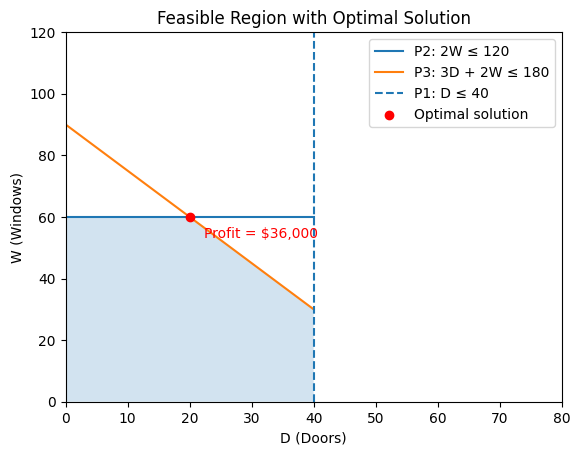

In [16]:
import numpy as np
import matplotlib.pyplot as plt


profit_D, profit_W = 300, 500
profit_opt = profit_D * D_opt + profit_W * W_opt

# ----- Plot feasible region and optimal solution -----
D_vals = np.linspace(0, cap_p1, 400)
W_p2 = np.full_like(D_vals, cap_p2/2)       # from Plant 2
W_p3 = (cap_p3 - 3*D_vals)/2                # from Plant 3

# Feasible region shading
W_upper = np.minimum(W_p2, W_p3)
W_upper = np.maximum(W_upper, 0)

plt.figure()
plt.plot(D_vals, W_p2, label="P2: 2W ≤ 120")
plt.plot(D_vals, W_p3, label="P3: 3D + 2W ≤ 180")
plt.axvline(cap_p1, linestyle="--", label="P1: D ≤ 40")
plt.fill_between(D_vals, 0, W_upper, alpha=0.2)

# Plot optimal point
plt.scatter([D_opt], [W_opt], color="red", zorder=5, label="Optimal solution")
plt.annotate(f"Profit = ${profit_opt:,.0f}", 
             (D_opt, W_opt), 
             textcoords="offset points", 
             xytext=(10, -15), 
             ha='left', color="red")

# Axis labels & title
plt.xlim(0, cap_p1*2)
plt.ylim(0, cap_p2)
plt.xlabel("D (Doors)")
plt.ylabel("W (Windows)")
plt.title("Feasible Region with Optimal Solution")
plt.legend()
plt.show()